# k-means clustering using discrete signatures

## 1. Prep Data

### 1.1. Load Data
We load the signature data and the knot data

In [1]:
import re, os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA  # For dimensionality reduction

In [12]:
filename = f'../results/tables/clustering_L15_W3_V0e+00_ARIstd0.96_ARInorm0.96_NMIstd0.90_NMInorm0.89_27May2025.csv' # replace with desired signatures to use

# extract clustering parameters from filename
match = re.search(r'L(\d+)_W(\d+)', filename)
if match:
    trunc_level = int(match.group(1))  # 15
    sig_weight = int(match.group(2))   # 2
else:
    raise ValueError("Filename format incorrect - missing L/W parameters")

print(f"trunc_level: {trunc_level}, sig_weight: {sig_weight}")

# Load the DataFrame from the CSV file
df = pd.read_csv(filename)

# Load the classification data
classification_df = pd.read_csv('../data/external/trefoil_list.csv')
# classification_df = classification_df[classification_df['Representative'] != 'Other']

# Ensure the 'Landscape' column matches between the two DataFrames
df['Chain'] = df['Chain'].astype(str)  # Ensure the column type is consistent
classification_df['Chain'] = classification_df['Chain'].astype(str)



trunc_level: 15, sig_weight: 3


In [13]:
# df

In [14]:
def safe_merge(df1, df2, merge_col='Chain', rep_col='Representative'):
    """
    Merges DataFrames while handling duplicate 'Representative' columns intelligently
    
    Args:
        df1, df2: DataFrames to merge
        merge_col: Column to merge on (default 'Chains')
        rep_col: Representative column name (default 'Representative')
    
    Returns:
        Merged DataFrame with a single Representative column
    """
    try:
        # Attempt merge with duplicate handling
        merged = df1.merge(df2, 
                          on=merge_col,
                          suffixes=('', '_y'))
        
        # Check if duplicate columns were created
        if f'{rep_col}_y' in merged.columns:
            # Verify values match if both columns exist
            if (merged[rep_col] == merged[f'{rep_col}_y']).all():
                merged = merged.drop(columns=[f'{rep_col}_y'])
            else:
                print("Warning: Representative values differ between DataFrames")
                # Keep both columns but rename for clarity
                merged = merged.rename(columns={
                    rep_col: f'{rep_col}_x',
                    f'{rep_col}_y': f'{rep_col}_y'
                })
        
        return merged
    
    except Exception as e:
        print(f"Merge failed: {str(e)}")
        # Fallback to simple merge if unexpected error occurs
        return df1.merge(df2, on=merge_col)



In [15]:
# Merge the DataFrames on the 'Landscape' column
try:
    merged_df = safe_merge(df, classification_df)
except Exception as e:
    print(f"Error during merge: {e}")
    merged_df = None

    
# Keep only rows where Representative is NOT 'other'
merged_df = merged_df[merged_df['Representative'] != 'Other']

# Select the columns corresponding to the signature
X = merged_df.drop(columns=['Landscape', 'Chain', 'Depth', 'Length', 'N-tail', 'C-tail', 'Representative','Depth_y','Length_y','N-tail_y','C-tail_y','Cluster_standardized','Cluster_normalized'])



In [16]:
# Display the merged DataFrame
# merged_df.describe()
# X.describe()

In [17]:
rep_list = merged_df['Representative'].unique()
len(rep_list)

9

### 1.2. Hyperparameters

In [78]:
n_clusters = len(rep_list) # Adjust if you don't want the same number of clusters as the number of rep classes
var_threshold = 0 # Adjust based on section 2. Ror the paper this was set at 0

### 1.3. Dimensionality reduction: ignoring features with low variance

In [18]:
# X.describe()

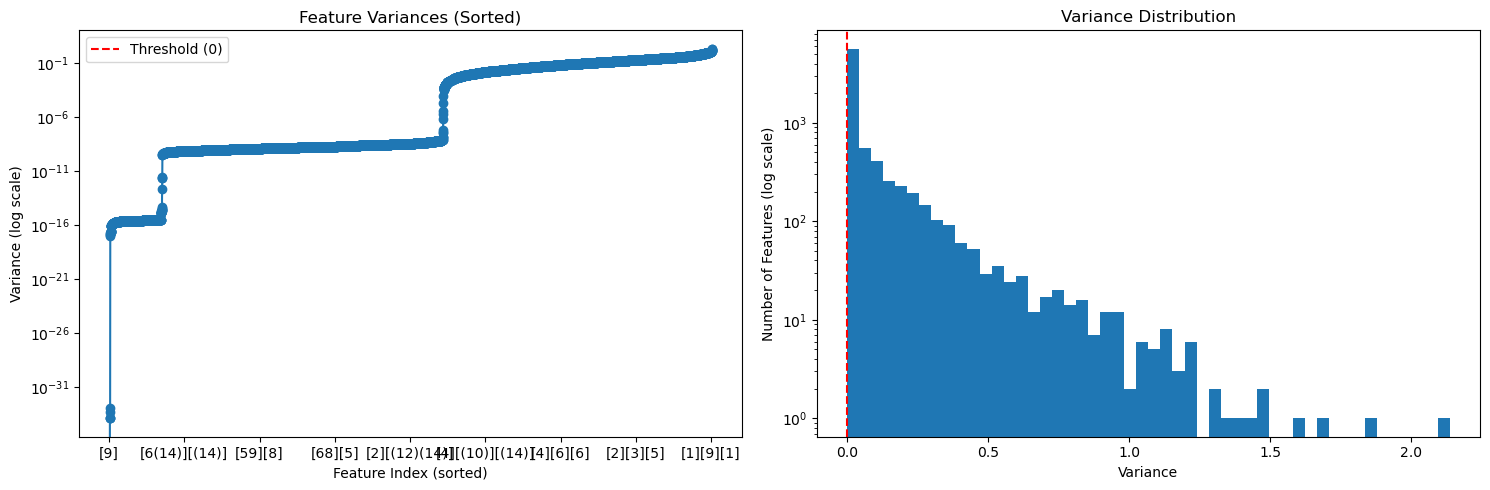

Variance Statistics:
count    8.015000e+03
mean     7.314729e-02
std      1.641564e-01
min      0.000000e+00
10%      5.818835e-10
25%      1.248029e-09
50%      3.533297e-09
75%      7.003393e-02
90%      2.372950e-01
max      2.136507e+00
dtype: float64

Features below variance thresholds:
1e-06: 4441 features (55.4%)
1e-04: 4445 features (55.5%)
1e-03: 4469 features (55.8%)
1e-02: 4831 features (60.3%)
1e-01: 6327 features (78.9%)

10 lowest-variance features:
[9]       0.0
[(11)]    0.0
[(14)]    0.0
[(15)]    0.0
[(10)]    0.0
[4]       0.0
[(12)]    0.0
[8]       0.0
[(13)]    0.0
[1]       0.0
dtype: float64

Original features: 8015
Features kept: 8005
Features removed: 10


In [79]:
# Plot variance
import pandas as pd

# 1. Calculate feature variances
variances = X.var(axis=0).sort_values()  # Series of variances sorted low to high

# 2. Plotting
plt.figure(figsize=(15, 5))

# Plot 1: Ordered variance plot
plt.subplot(1, 2, 1)
variances.plot(logy=True, marker='o', title='Feature Variances (Sorted)')
plt.axhline(y=var_threshold, color='r', linestyle='--', label=f'Threshold ({var_threshold})')
plt.ylabel('Variance (log scale)')
plt.xlabel('Feature Index (sorted)')
plt.legend()

# Need to adjust plaot 2!!
# Plot 2: Variance distribution
plt.subplot(1, 2, 2)
plt.hist(variances, bins=50, log=True)
plt.axvline(x=var_threshold, color='r', linestyle='--')
plt.title('Variance Distribution')
plt.xlabel('Variance')
plt.ylabel('Number of Features (log scale)')

plt.tight_layout()
plt.show()

# 3. Variance statistics
print("Variance Statistics:")
print(variances.describe(percentiles=[.1, .25, .5, .75, .9]))

# 4. Count features below potential thresholds
thresholds = [1e-6, 1e-4, 1e-3, 0.01, 0.1]
print("\nFeatures below variance thresholds:")
for thresh in thresholds:
    n_below = (variances < thresh).sum()
    print(f"{thresh:.0e}: {n_below} features ({n_below/len(variances):.1%})")

# 5. Show lowest-variance features
print("\n10 lowest-variance features:")
print(variances.head(10))

# 6. Apply your chosen threshold
selector = VarianceThreshold(threshold=var_threshold)
X_filtered = selector.fit_transform(X)

# Create new DataFrame with kept features
kept_features = X.columns[selector.get_support()]
df_filtered = pd.DataFrame(X_filtered, columns=kept_features)

print(f"\nOriginal features: {X.shape[1]}")
print(f"Features kept: {df_filtered.shape[1]}")
print(f"Features removed: {X.shape[1] - df_filtered.shape[1]}")

In [80]:
# Update your signatures after discrding low variance features
X= df_filtered
# X.describe()

,[111],[112],[113],[114],[115],[116],[117],[118],[119],[11(10)],...,[(15)][(15)][6],[(15)][(15)][7],[(15)][(15)][8],[(15)][(15)][9],[(15)][(15)][(10)],[(15)][(15)][(11)],[(15)][(15)][(12)],[(15)][(15)][(13)],[(15)][(15)][(14)],[(15)][(15)][(15)]
count,3.630000e+02,3.630000e+02,3.630000e+02,3.630000e+02,3.630000e+02,3.630000e+02,3.630000e+02,3.630000e+02,3.630000e+02,3.630000e+02,...,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,3.630000e+02
mean,-4.302445e-05,-1.537689e-07,2.612860e-09,1.435533e-08,2.197751e-08,2.543603e-08,2.662712e-08,2.746906e-08,2.819171e-08,2.876732e-08,...,0.172714,0.157541,0.142940,0.122043,0.102439,0.080610,0.060168,0.040369,0.022643,9.746091e-09
std,7.903955e-04,1.483385e-06,5.087816e-08,3.570470e-08,1.106760e-08,9.543533e-09,1.238999e-08,1.345409e-08,1.394622e-08,1.470323e-08,...,0.080334,0.077226,0.069613,0.065036,0.059216,0.050894,0.040098,0.026611,0.018161,5.406932e-09
min,-1.462510e-02,-2.806469e-05,-3.552047e-07,-3.466895e-07,-4.210161e-08,-1.437262e-08,-1.962622e-08,-2.028314e-08,-1.402741e-08,-1.448840e-08,...,-0.000841,-0.013357,-0.015414,-0.024268,-0.026348,-0.023051,-0.029317,-0.028488,-0.021498,-1.173005e-09
25%,-3.752041e-07,-1.357440e-07,2.252521e-09,1.419363e-08,2.012989e-08,2.463933e-08,2.731418e-08,2.901293e-08,2.970053e-08,2.997106e-08,...,0.117245,0.096610,0.077392,0.069582,0.044835,0.030494,0.019066,0.015570,0.007716,1.028030e-08
50%,-2.233937e-07,-6.713342e-08,1.271257e-08,1.931787e-08,2.354953e-08,2.833495e-08,3.204267e-08,3.361851e-08,3.488661e-08,3.648763e-08,...,0.196674,0.181217,0.168076,0.148083,0.129576,0.100420,0.075582,0.049959,0.026061,1.280521e-08
75%,-1.801313e-07,-1.662425e-08,2.137378e-08,2.382163e-08,2.726718e-08,3.064571e-08,3.338107e-08,3.440048e-08,3.586892e-08,3.732261e-08,...,0.214669,0.204013,0.187218,0.168006,0.147187,0.117939,0.089231,0.059626,0.035410,1.308629e-08
max,2.913637e-03,1.750467e-06,7.952959e-08,8.979852e-08,5.030346e-08,4.181856e-08,4.180114e-08,4.275930e-08,3.966442e-08,3.947162e-08,...,0.496277,0.428245,0.381637,0.324600,0.283701,0.244910,0.209672,0.114877,0.079787,1.382038e-08


### 1.4. Standardize the data

In [81]:
from sklearn.preprocessing import StandardScaler,  MinMaxScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the data
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Display the standardized DataFrame
# print(X_standardized)

## 2. Perform k-means on prepped data

In [82]:
# k-mean on the standardized data

# Perform k-Means clustering
kmeans = KMeans(n_clusters, random_state=42)  # Choose the number of clusters
clusters_std = kmeans.fit_predict(X_standardized)

# Add the cluster labels to the DataFrame
merged_df['Cluster_standardized'] = clusters_std

## 3. Compare k-means and classification by representative (sequence similarity) 
We now check compatibility between the k-means clustering(s) and the classification in terms of the knot representative

In [83]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
# Extract the ground truth labels and cluster labels
true_labels = merged_df['Representative']
cluster_std_labels = merged_df['Cluster_standardized'].astype(str)

print(f"Variance Threshold: {var_threshold}")
# Compute the Adjusted Rand Index (ARI)
ari_std = adjusted_rand_score(true_labels, cluster_std_labels)
print(f"Adjusted Rand Index (ARI) [Standardized data]: {ari_std:.2f}")

# Compute the Normalized Mutual Information (NMI)
nmi_std = normalized_mutual_info_score(true_labels, cluster_std_labels)
print(f"Normalized Mutual Information (NMI): {nmi_std:.2f}")

Variance Threshold: 0
Adjusted Rand Index (ARI) [Standardized data]: 0.96
Normalized Mutual Information (NMI): 0.90


### 3.1. [Optional] Save the large dataframe

In [84]:
# Optional: save the large data frame
from datetime import datetime

# Human-readable date (e.g., "21May2024")
date_str = datetime.now().strftime("%d%b%Y")  # %b = abbreviated month (Jan, Feb, etc.)

# Compact metrics notation (adjust precision as needed)
metrics_str = f"A{ari_std:.2f}_N{nmi_std:.2f}"

# Final filename
filename = (
    f"../results/tables/clustering_L{trunc_level}_W{sig_weight}_V{var_threshold:.0e}_"
    f"ARIstd{ari_std:.2f}_"
    f"NMIstd{nmi_std:.2f}_"
    f"{date_str}.csv"
)
merged_df.to_csv(filename, index=False)
print(f"Saved: {filename}")

Saved: ../results/tables/clustering_L15_W3_V0e+00_ARIstd0.96_NMIstd0.90_27May2025.csv


### 3.2 Log results in Master dataframe

In [13]:
# Initialize empty DataFrame (if starting fresh)
# columns = [
#     'variance_threshold', 'truncation_level', 'signature_weight', 'n_clusters',
#     'ARI_standardized', 'ARI_normalized', 'NMI_standardized', 'NMI_normalized'
# ]
# master_results_df = pd.DataFrame(columns=columns)

# # Add first entry
# new_entry = {
#     'variance_threshold': -1,
#     'truncation_level': 4,
#     'signature_weight': 2,
#     'n_clusters': 6,
#     'ARI_standardized': 0.38,
#     'NMI_standardized': 0.30,
# }
# master_results_df = pd.concat([master_results_df, pd.DataFrame([new_entry])], ignore_index=True)

In [87]:
# Load DataFrame if continuing to add results
try:
    master_results_df = pd.read_csv('../results/tables/master_results_comparison_kmeans_sig_V_representatives_x1_dropOther.csv', encoding='utf-8')
    print("Loaded successfully! Shape:", master_results_df.shape)
except FileNotFoundError:
    print("File not found!")
except Exception as e:
    print("Error:", str(e))

Loaded successfully! Shape: (10, 6)


In [88]:
# Verify load
# print(master_results_df.head())  # First 5 rows
# print(master_results_df.info())  # Data types and memory usage
master_results_df

,variance_threshold,truncation_level,signature_weight,n_clusters,ARI_standardized,NMI_standardized
0,0.000000e+00,10.0,2.0,9.0,0.455478,0.634319
1,0.000000e+00,10.0,2.0,7.0,0.867993,0.747505
2,0.000000e+00,10.0,2.0,5.0,0.746163,0.704894
3,0.000000e+00,10.0,2.0,8.0,0.468378,0.634098
4,0.000000e+00,10.0,2.0,6.0,0.731497,0.683264
5,0.000000e+00,10.0,2.0,15.0,0.370048,0.635436
6,0.000000e+00,5.0,3.0,8.0,0.586025,0.527567
7,1.000000e-09,5.0,3.0,9.0,0.496869,0.482446
8,0.000000e+00,15.0,2.0,9.0,0.538607,0.738347
9,0.000000e+00,15.0,3.0,9.0,0.949612,0.869305


In [19]:
# Add next entry
# master_results_df.loc[len(master_results_df)] = [
#     var_threshold,  # variance_threshold
#     trunc_level,     # truncation_level
#     sig_weight,     # signature_weight
#     n_clusters,    # n_clusters
#     ari_std,  # ARI_standardized
#     nmi_std,  # NMI_standardized
# ]

In [20]:
# master_results_df

In [21]:
# Save results

# # Generate the filename
# filename = f'../results/tables/master_results_comparison_kmeans_sig_V_representatives_x1_dropOther.csv'

# # Save the DataFrame
# master_results_df.to_csv(filename, index=False)

# print(f"Data saved to {filename}")

## 4. Visualize results

(Optional) Load previously computed clustering 

In [2]:
# Load the DataFrame from the CSV file
clustering_file =  f'../results/tables/clustering_L15_W3_V0e+00_ARIstd0.96_ARInorm0.96_NMIstd0.90_NMInorm0.89_27May2025.csv'
merged_df = pd.read_csv(clustering_file)

In [7]:
# merged_df

### 4.1. Histogram

In [10]:
# Custom color scheme compatible with the proteins paper
rep_classes = ['4QEF', '1FUG', '1J85', '1UAK', 
               '3ZNC', '2V3J', '3KZK', '6QQW', '6RQQ']
rep_colors = [
    '#1A4B8C',  # denim blue (4qef_A)
    '#B784A7',  # mauve (1fug_A)
    '#FF69B4',  # BRIGHT PINK (1j85_A) - changed from #FFC0CB
    '#228B22',  # green (1uak_A)
    '#FFA500',  # orange (3znc_A)
    '#FF0000',  # red (2v3j_A)
    '#87CEEB',  # sky blue (3kzk_A)
    '#FFFF00',  # yellow (6qqw_A)
    '#2A0A5E'   # dark blue-violet (6rqq_A)
]
rep_color_dict = dict(zip(rep_classes, rep_colors))

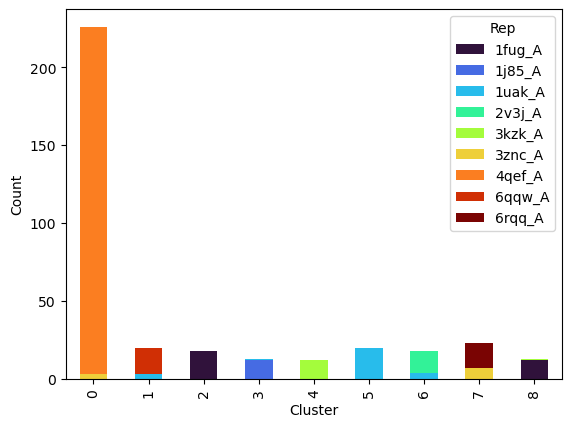

In [4]:
# Create a cross-tabulation of clusters and classes
cross_tab = pd.crosstab(merged_df['Cluster_standardized'], merged_df['Representative'])

# Plot the stacked bar plot
cross_tab.plot(kind='bar', stacked=True, colormap='turbo')
# plt.title("Cluster vs Class Representative Distribution")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Rep")
plt.show()

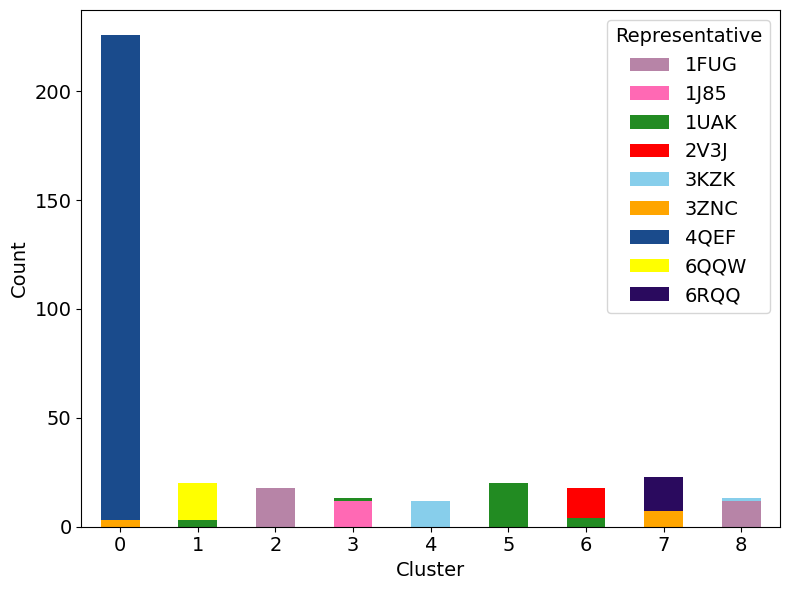

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Create cross-tabulation
cross_tab = pd.crosstab(merged_df['Cluster_standardized'], merged_df['Representative'])

# Custom settings
custom_colors = rep_color_dict  # Modify as needed

# Remove "_A" from labels AND convert to uppercase
cross_tab.columns = cross_tab.columns.str.replace('_A$', '', regex=True).str.upper()

# Create plot with full customization
fig, ax = plt.subplots(figsize=(8, 6))

cross_tab.plot(kind='bar', stacked=True, 
               color=custom_colors,  # Use custom colors
               ax=ax)

# Axis and label formatting
ax.set_xlabel("Cluster", fontsize=14)  # Adjust fontsize
ax.set_ylabel("Count", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)  # Tick label size
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Horizontal x-axis ticks

# Legend customization
legend = ax.legend(title="Representative", 
          # bbox_to_anchor=(1.05, 1),  # Moves legend outside plot
          loc='upper right',
          fontsize=14,
                  title_fontsize =14)  # Legend font size
plt.tight_layout()  # Prevents label cutoff
# plt.show()

In [34]:
# Save the figure
from datetime import datetime
# trunc_level = 15
# sig_weight = 3
# var_threshold = 0
# n_clusters = 9
# Human-readable date (e.g., "21May2024")
date_str = datetime.now().strftime("%d%b%Y")  # %b = abbreviated month (Jan, Feb, etc.)


hist_figname= f'../results/fig/hplot_cluster_v_rep_x1_L{trunc_level}_W{sig_weight}_thresh_{var_threshold}_Clusters_{n_clusters}_{date_str}.png'
fig.savefig(hist_figname, dpi=300, bbox_inches='tight')
# fig.close()  # Prevents duplicate display in notebook

### 4.2. Format the results table for better display

In [23]:
Y = master_results_df.drop(columns=['variance_threshold'])
Y = Y.rename(columns={'ARI_standardized': 'ARI', 'NMI_standardized': 'NMI'})
new_order = ['truncation_level', 'signature_weight', 'n_clusters', 
             'ARI', 'NMI']

In [24]:
def highlight_top_rows(row):
    return ['background-color: yellow' if row['ARI'] > 0.9 else '' for _ in row]


In [25]:
# Style integers as integers, floats with 2 decimals
styled_df = Y.sort_values('ARI', ascending=False).style.format({
    'truncation_level': '{:.0f}',         # No decimals for integers
    'signature_weight' : '{:.0f}',
    'n_clusters' : '{:.0f}',
    'ARI': '{:.3f}',         # 2 decimals for metrics
    'NMI': '{:.3f}'
}).apply(highlight_top_rows, axis=1).set_properties(**{
    'border': '1px solid black',
    'text-align': 'center'
}).set_table_styles([
    {  # Style for headers
        'selector': 'th',
        'props': [
            ('background-color', '#404040'),
            ('color', 'white'),
            ('width', '100px')  # Fixed width for all headers
        ]
    },
    {  # Style for data cells (to match headers)
        'selector': 'td',
        'props': [
            ('width', '100px')  # Same width as headers
        ]
    }
])

In [26]:
styled_df = styled_df.apply(highlight_top_rows, axis=1)
print(styled_df)

,truncation_level,signature_weight,n_clusters,ARI,NMI
9,15,3,9,0.950,0.869
1,10,2,7,0.868,0.748
2,10,2,5,0.746,0.705
4,10,2,6,0.731,0.683
6,5,3,8,0.586,0.528
8,15,2,9,0.539,0.738
7,5,3,9,0.497,0.482
3,10,2,8,0.468,0.634
0,10,2,9,0.455,0.634
5,10,2,15,0.370,0.635


## 5. Comparison to direct landscape-based clustering
We now perform Kmeans directly using landscapes as feature vectors. More precisely, we obtain feature vectos by evaluating all (truncated) landscapes on the union of all critical points for the dataset D.

### 5.1 Landscape-based clustering
We compute the ARI and NMI for the Kmeans clustering, using the same number of clusters (9) as representative classes

In [32]:
# Input directory
directory = "../src/ph-knotted-proteins/data/validation/landscapes/interpolated_x1"  # Replace with your directory path to the landscapes
trunc_level = 15

Edit the function below so we only load the landscapes that are not labeled by "Other" as representative

Finding filenames that don't correspond to proteins labeled by "Other"

In [25]:
# Keep only rows where Representative is NOT 'other'
# merged_df = merged_df[merged_df['Representative'] != 'Other']
list_non_other = merged_df['Chain']

In [27]:
list_non_other

0       1cak_A
1       1cao_A
2       1cng_A
3       1cnh_A
4       1cnj_A
        ...   
358    6rxv_CN
359    6rxx_CN
360    6rxy_CN
361    6rxz_CN
362     6uev_A
Name: Chain, Length: 363, dtype: object

In [35]:
file_list = [
    fname for fname in os.listdir(directory)
    if fname.endswith('1.lan') 
    and any(fname.startswith(prefix) for prefix in list_non_other)
]
file_list.sort()

In [37]:
# len(file_list)

363

In [38]:
def load_lan_file(filename, trunc_level):
    """
    Reads a .lan file and returns a list of levels truncated (or extended)
    to trunc_level.
    
    Each level is represented as a list of (epsilon, critical_value) tuples.
    The file is assumed to have header lines (starting with '#' or '%') indicating
    the beginning of a new level. Critical points for a level appear on subsequent lines.
    This is the standard format of .lan files.
    """
    levels = []
    current_points = []
    current_level_count = 0

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith('#') or line.startswith('%'):
                # Header encountered: finish the previous level if present.
                if current_points:
                    levels.append(current_points)
                    current_points = []
                    current_level_count += 1
                    if current_level_count == trunc_level:
                        break
                continue
            # Only parse data if we haven't reached the truncation limit.
            if current_level_count < trunc_level:
                tokens = line.split()
                if len(tokens) != 2:
                    raise ValueError("Expected exactly two tokens per critical point line, got: " + str(tokens))
                eps = float(tokens[0])
                val = float(tokens[1])
                current_points.append((eps, val))
    # Append any remaining points as the last level.
    if current_points and current_level_count < trunc_level:
        levels.append(current_points)
        current_level_count += 1

    # If there are fewer than trunc_level levels, extend with empty lists.
    while current_level_count < trunc_level:
        levels.append([])
        current_level_count += 1

    return levels

def eval_landscape(points, t):
    """
    Evaluate a landscape function defined by a list of (epsilon, value) tuples
    at a given epsilon value t via linear interpolation. The function is assumed 
    to be zero outside the range of the provided points.
    """
    if not points:
        return 0.0
    # t is outside the range -> return 0.
    if t < points[0][0] or t > points[-1][0]:
        return 0.0
    # Find the interval [x0, x1] in which t lies.
    for i in range(1, len(points)):
        x0, y0 = points[i-1]
        x1, y1 = points[i]
        if x0 <= t <= x1:
            if t == x0:
                return y0
            if t == x1:
                return y1
            # Linear interpolation.
            return y0 + (y1 - y0) * (t - x0) / (x1 - x0)
    return 0.0

def process_directory_to_3d(directory, trunc_level):
    """
    Processes all .lan files in the directory and returns a 3D NumPy array
    of time series data and an ordering dictionary.
    
    The output 3D array has shape (N, trunc_level, T) where:
      - N = number of landscapes (files)
      - trunc_level = number of levels per landscape (as specified)
      - T = number of unique epsilon values across all files
    The epsilon axis is common for all landscapes.
    
    Also returns:
      - ordering: a dictionary mapping each filename (without full path)
                   to its index in the 3D array.
      - global_epsilon: the sorted list of all unique epsilon values.
    """
    all_epsilons = set()
    file_list = []

    # First, gather all .lan filenames.
    file_list = [
    fname for fname in os.listdir(directory)
    if fname.endswith('1.lan') 
    and any(fname.startswith(prefix) for prefix in list_non_other)
    ]
    file_list.sort()

    # First pass: Accumulate epsilon values from all files.
    for fname in file_list:
        fpath = os.path.join(directory, fname)
        levels_data = load_lan_file(fpath, trunc_level)
        for level in levels_data:
            for (eps, _) in level:
                all_epsilons.add(eps)
    global_epsilon = sorted(all_epsilons)
    T = len(global_epsilon)

    landscapes = []    # to store the time series matrices for each file
    ordering = {}      # maps filename to its index in the 3D array

    # Second pass: For each file, evaluate the landscape at all global epsilon values.
    for idx, fname in enumerate(file_list):
        fpath = os.path.join(directory, fname)
        levels_data = load_lan_file(fpath, trunc_level)
        ts_matrix = np.zeros((trunc_level, T))
        for lev in range(trunc_level):
            pts = levels_data[lev]  # list of (eps, value) for this level (may be empty)
            for j, t in enumerate(global_epsilon):
                ts_matrix[lev, j] = eval_landscape(pts, t)
        landscapes.append(ts_matrix)
        ordering[fname] = idx

    # Stack into a 3D array: shape (N, trunc_level, T)
    result_array = np.stack(landscapes, axis=0)
    return result_array, ordering, global_epsilon

In [39]:
%%time

landscape_array, ordering_dict, global_eps = process_directory_to_3d(directory, trunc_level)

print("3D Array shape (landscapes, levels, epsilon):", landscape_array.shape)
# print("Ordering dictionary (filename -> index):")
# print(ordering_dict)
# print("Global epsilon values:")
# print(global_eps)

3D Array shape (landscapes, levels, epsilon): (363, 15, 112048)
CPU times: user 8min 23s, sys: 1.39 s, total: 8min 24s
Wall time: 8min 24s


In [44]:
import numpy as np

# Assuming landscape_array is your 3D array
d1, d2, d3 = landscape_array.shape

# Reshape to merge dimensions 2 and 3
flattened_array = landscape_array.reshape(d1, d2 * d3)


In [45]:
print("Original shape:", landscape_array.shape)
print("Flattened shape:", flattened_array.shape)
print("Non-zero count:", np.count_nonzero(flattened_array))

Original shape: (363, 15, 112048)
Flattened shape: (363, 1680720)
Non-zero count: 538679262


In [46]:
# now use the landscapes themselves as feature vectors for the kmeans clustering
# k-mean on the standardized data

# Perform k-Means clustering
kmeans = KMeans(9, random_state=42)  # Choose the number of clusters
clusters_land = kmeans.fit_predict(flattened_array)

In [49]:
# Check that the ordering on the landscape_array matches the ordering of the representatives
# ordering_dict.keys() == merged_df['Chain']
ordering_flattened_array = []
for key in ordering_dict.keys():
    if key.endswith('_1.lan'):
        # Remove the last 6 characters ('_1.lan')
        base_name = key[:-6]
        ordering_flattened_array.append(base_name)


In [53]:
if (ordering_flattened_array == merged_df['Chain']).all():
    print('yay')

yay


In [54]:
# Evaluate ARI and NMI scores
# Extract the ground truth labels and cluster labels
true_labels = merged_df['Representative']

# print(f"Variance Threshold: {var_threshold}")
# Compute the Adjusted Rand Index (ARI)
ari_std = adjusted_rand_score(true_labels, clusters_land)
print(f"Adjusted Rand Index (ARI) : {ari_std:.2f}")

# Compute the Normalized Mutual Information (NMI)
nmi_std = normalized_mutual_info_score(true_labels, clusters_land)
print(f"Normalized Mutual Information (NMI): {nmi_std:.2f}")

Adjusted Rand Index (ARI) : 0.88
Normalized Mutual Information (NMI): 0.83
